In [1]:
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(w, h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx]
        image = image.reshape(image_height, image_width)
        plt.imshow(image, cmap='gray')
        plt.title(LABELS[np.argmax(labels[idx])])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [3]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(w, h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(image_height, image_width)
#         image = image.astype(np.uint8)
        plt.imshow(image, cmap='gray')
        plt.title(LABELS[label])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [45]:
def predict_image(img_file, model=None):
    plt.figure(figsize=(5, 5))
    img = load_img(img_file)  
    plt.imshow(img)    
    
    img = img.resize(size=(image_width, image_height))
    img = img.convert('L')
#     plt.imshow(img)
    x = img_to_array(img)
#     x = (x - np.min(x)) / (np.max(x) - np.min(x))    
    x = x.reshape(1, image_height, image_width, n_channels)    
    
    class_probs = model.predict(x)
    label = LABELS[np.argmax(class_probs)]
    conf = 100 * np.max(class_probs)
    
    plt.title('%s (%0.2f%%)' % (label, conf))
    plt.xticks([])
    plt.yticks([])

In [5]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [6]:
def load_data():
    data = []
    labels = []
    
    for file in Path(IMG_DIR).iterdir():
        if not file.is_file():
            continue
        try:
            x = load_img(file, color_mode='grayscale')
        except Exception as e:
            print('Unable to load %s' % f)
            continue
        x = img_to_array(x)
        x = x.reshape(image_height, image_width, n_channels)
        data.append(x)
        label = LABELS.index(file.name.split('.')[-2][-1])
        labels.append(label)
    
    data = np.array(data)
    labels = np.array(labels)
    
    x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2)
    y_train = to_categorical(y_train, len(LABELS))
    y_val = to_categorical(y_val, len(LABELS))
    
    return x_train, y_train, x_val, y_val

In [12]:
IMG_DIR = 'images/hard/'
LABELS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# LABELS = ALPHA + ALPHA.lower()  # For insane mode

In [8]:
n_channels = 1
image_height, image_width = 32, 32

In [13]:
x_train, y_train, x_val, y_val = load_data()

In [14]:
print([data.shape for data in [x_train, y_train, x_val, y_val]])

[(8000, 32, 32, 1), (8000, 26), (2000, 32, 32, 1), (2000, 26)]


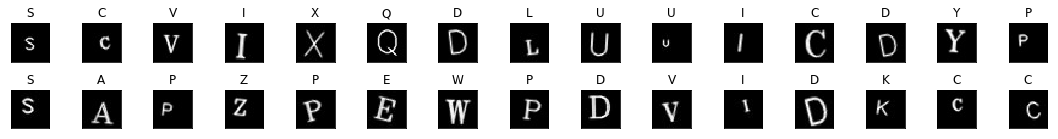

In [15]:
show_random_images(x_train, y_train, h=2, w=15)

In [16]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, n_channels),
                     data_format='channels_last'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=len(LABELS), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [18]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 6s 703us/step - loss: 3.3773 - acc: 0.0410 - val_loss: 3.2578 - val_acc: 0.0320
Epoch 2/20
8000/8000 [==============================] - 6s 758us/step - loss: 3.2441 - acc: 0.0523 - val_loss: 3.1793 - val_acc: 0.0650
Epoch 3/20
8000/8000 [==============================] - 8s 986us/step - loss: 3.0970 - acc: 0.0880 - val_loss: 2.8881 - val_acc: 0.1020
Epoch 4/20
8000/8000 [==============================] - 5s 581us/step - loss: 2.8448 - acc: 0.1195 - val_loss: 2.6249 - val_acc: 0.1640
Epoch 5/20
8000/8000 [==============================] - 6s 718us/step - loss: 2.4633 - acc: 0.2086 - val_loss: 1.9262 - val_acc: 0.3665
Epoch 6/20
8000/8000 [==============================] - 4s 560us/step - loss: 1.8760 - acc: 0.4040 - val_loss: 1.1226 - val_acc: 0.6685
Epoch 7/20
8000/8000 [==============================] - 6s 776us/step - loss: 1.3851 - acc: 0.5613 - val_loss: 0.7418 - val_acc: 0.7910


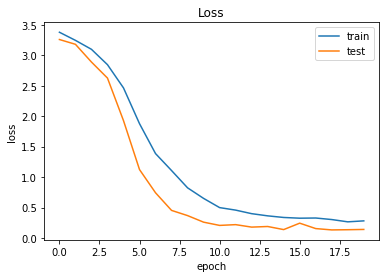

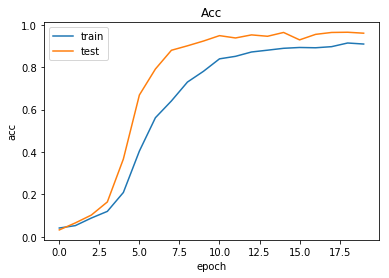

In [19]:
plot_history(history)

In [22]:
# Better with min-max scaling
acc = 100 * model.evaluate(x_val, y_val, verbose=0)[1]
print('Model val acc: %0.2f%%' % acc)

Model val acc: 96.00%


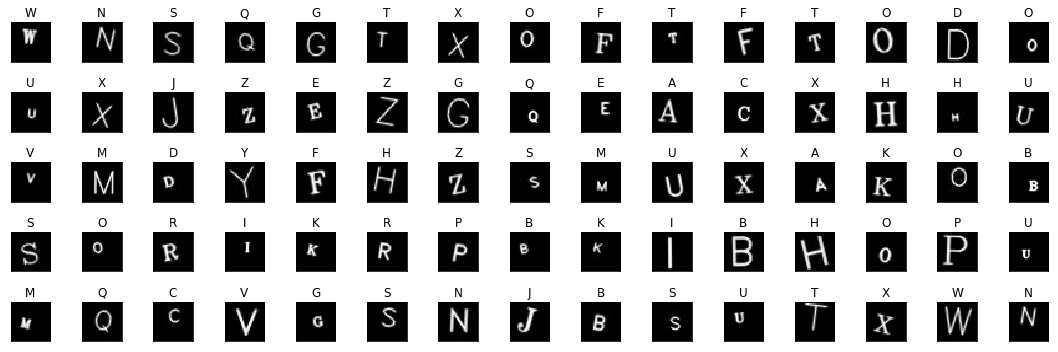

In [23]:
predict_random_images(x_val, model, 5, 15)

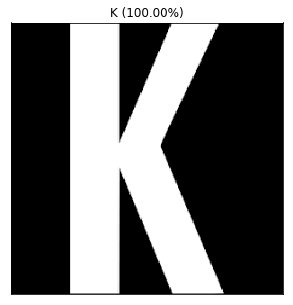

In [51]:
predict_image('k.png', model)